In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

In [ ]:
from utils import decompose_by_frames

In [2]:
path_shaky = r'Selfie Video Compilation Part 1 l TC.mp4'
output_directory = r'shaky_example'


decompose_by_frames(path_shaky, output_directory)

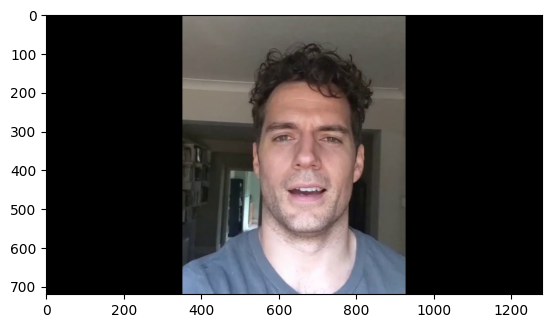

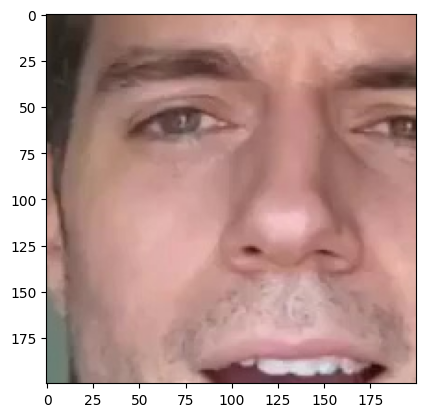

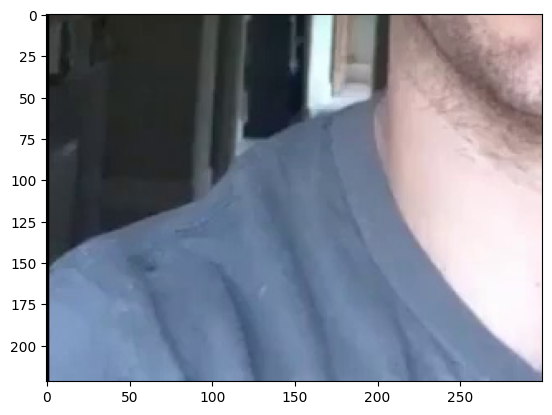

In [3]:
path_shaky = r'Selfie Video Compilation Part 1 l TC.mp4'
output_directory = r'shaky_example'

pathlist = sorted(list(Path(output_directory).rglob('*')), key=lambda x: int(x.stem.split('_')[1]))

for idx, i in enumerate(pathlist):
    img = cv2.imread(str(i))[..., ::-1]
    plt.imshow(img)
    plt.show()

    #### head ####
    hh = img.shape[0]//2
    # hh = 100
    ww = img.shape[1]//2
    g = 100
    crop = img[hh-g : hh+g, ww-g : ww+g, :]
    plt.imshow(crop)
    plt.show()
    #### head ####

    #### shoulder ####
    hh = img.shape[0]*0.9
    hh=int(hh)
    ww = 500
    ww=int(ww)
    g = 150
    crop = img[hh-g : hh+g, ww-g : ww+g, :]
    plt.imshow(crop)
    plt.show()
    #### shoulder ####


    if idx == 0:
        break

In [9]:
def visualize_optical_flow(flow):
    magnitude, direction = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    hue = direction * 180 / np.pi / 2
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 0] = hue
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

def analyze_camera_shake(output_directory):
    index = 900 # first 30 second
    optical_flow_params = dict(pyr_scale=0.5, levels=3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.1, flags=0)
    move_vector = []
    pathlist = sorted(list(Path(output_directory).rglob('*')), key=lambda x: int(x.stem.split('_')[1]))
    prev_frame = cv2.imread(str(pathlist[0]))
    for i in pathlist[1:index]:
        curr_frame = cv2.imread(str(i))
        prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, **optical_flow_params)
        motion_x = flow[..., 0]
        motion_y = flow[..., 1]
        
        hh = curr_frame.shape[0]*0.9
        hh=int(hh)
        ww = 500
        ww=int(ww)
        g = 150
        
        x_mean = motion_x[hh-g : hh+g, ww-g : ww+g].mean()
        y_mean = motion_y[hh-g : hh+g, ww-g : ww+g].mean()
        move_vector.append((x_mean, y_mean))
        prev_frame = curr_frame
    return move_vector

video_paths = [r'output_directory']
all_scales = []
all_directions = []
all_directions_x=[]
all_directions_y=[]
all_move_vector=[]
for video_path in video_paths:
    move_vector = analyze_camera_shake(video_path)
    all_move_vector.extend(move_vector)

In [10]:
with open('henry_kavil_moves.pkl', 'wb') as file:
    pickle.dump(all_move_vector, file)

In [11]:
scalemove = 10
frame = np.zeros((512,512))
init_x, init_y = 256, 256
frame[init_x, init_y] = 255
for idx, (x,y) in enumerate(all_move_vector):
    # print(idx)
    init_x += x*scalemove
    init_y += y*scalemove
    # print(init_x, x, init_y, y)
    frame[int(init_x), int(init_y)] = 255
    # if idx > 10:
    #     break

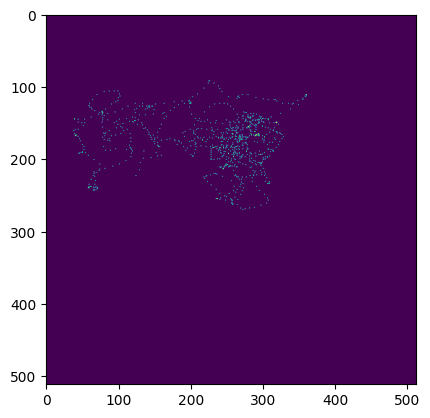

In [12]:
plt.imshow(frame)

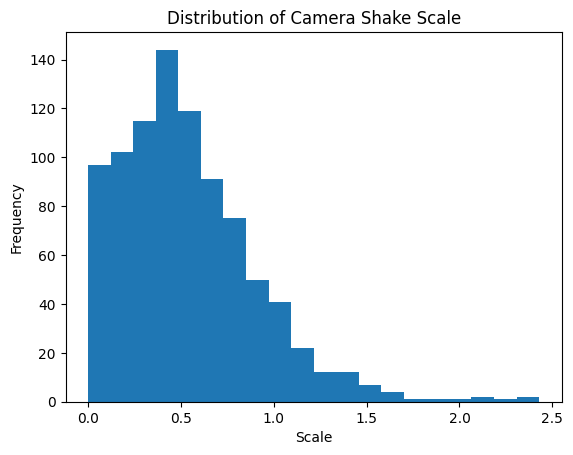

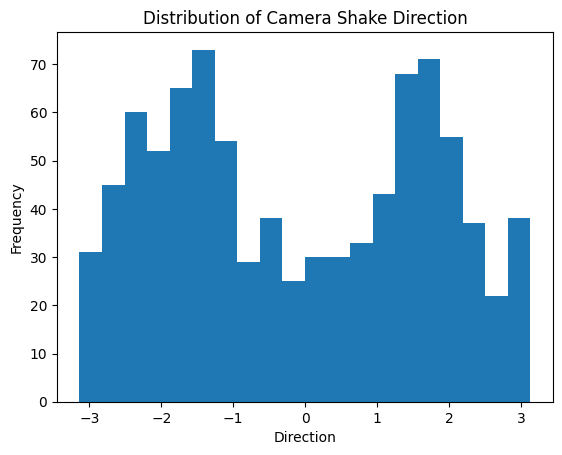

In [17]:
all_scales = []
directions = []
for x,y in all_move_vector:
    magnitude = np.sqrt(x**2 + y**2)
    direction = np.arctan2(y, x)
    all_scales.append(magnitude)
    directions.append(direction)
    
    # direction = np.arctan2(motion_y, motion_x)
    # scales.extend(magnitude.flatten())
    # directions.extend(direction.flatten())
all_scales = np.array(all_scales)
directions = np.array(directions)

plt.hist(all_scales, bins=20)
plt.xlabel('Scale')
plt.ylabel('Frequency')
plt.title('Distribution of Camera Shake Scale')
plt.show()

plt.hist(directions, bins=20)
plt.xlabel('Direction')
plt.ylabel('Frequency')
plt.title('Distribution of Camera Shake Direction')
plt.show()